In [1]:
import sys

# Add models path
sys.path.append("../")

In [10]:
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from utils import MNIST, accuracy

In [3]:
data_path = Path('../data/test')

In [6]:
test_dataset = MNIST(
    root=data_path,
    download=True,
    transform=ToTensor()
)

Downloading: train dataset...
Extracting: train dataset...
Writing to disk: train dataset...
Downloading: t10k dataset...
Extracting: t10k dataset...
Writing to disk: t10k dataset...


In [7]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/test
    StandardTransform
Transform: ToTensor()

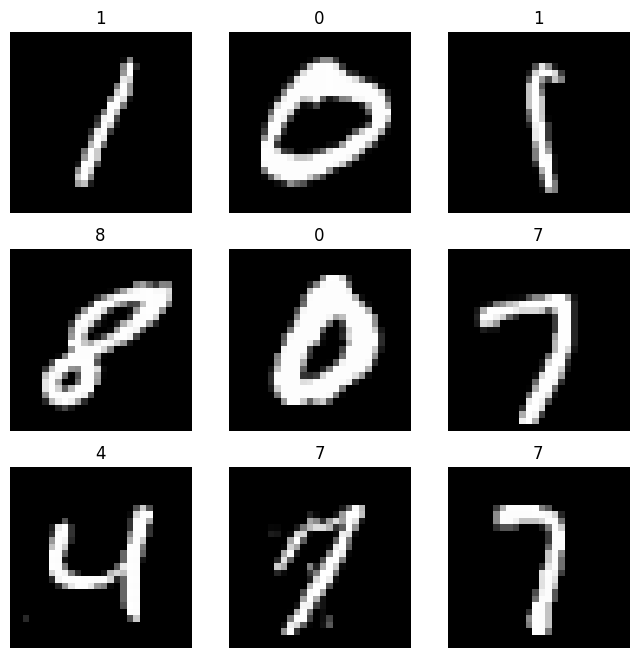

In [8]:
test_dataset.show_batch()

In [9]:
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [11]:
# Get cpu, gpu or mps device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [12]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [13]:
from models.LeNet5.arch import LeNet5

In [14]:
models_path = Path('../models/')
LeNet5_model_path = models_path / "LeNet5/LeNet5.pth"

In [17]:
model = LeNet5().to(device)
model.load_state_dict(torch.load(LeNet5_model_path, map_location=torch.device(device)))

print(model)

LeNet5(
  (layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [18]:
loss_fn = nn.CrossEntropyLoss()

In [19]:
def test(dataloader, model, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    y_true = []
    y_pred = []
    len_dataset = len(dataloader.dataset)
    num_batches = dataloader.batch_size
    with torch.no_grad():
        for X, y in dataloader:
            # Forward pass
            X, y = X.to(device), y.to(device)
            preds = model(X)

            # Compute prediction error and accuracy
            loss += loss_fn(preds, y).item()
            acc += accuracy(y, preds)

            y_true.extend(y.tolist())
            y_pred.extend(preds.tolist())

    loss /= num_batches
    acc = 100.0 * (acc / len_dataset)
    target_names = [str(label) for label in range(10)]

    print(
        f'Test set: Average loss: {loss:>3.3f}, Accuracy: {acc:>3.3f}%')

    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred).argmax(axis=-1)
    
    return y_true, y_pred, target_names

In [20]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [21]:
y_true, y_pred, target_names = test(test_dataloader, model, loss_fn)

Test set: Average loss: 0.088, Accuracy: 98.750%


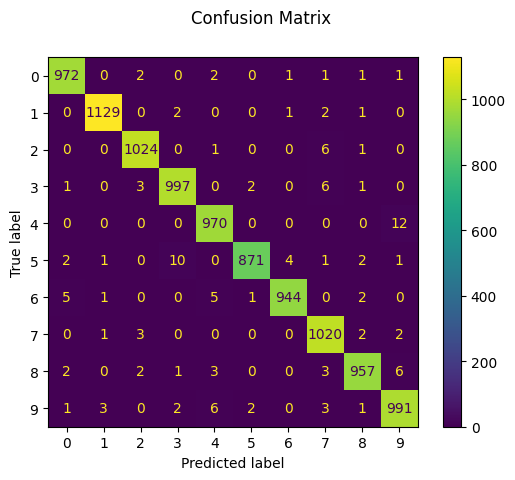

In [22]:
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Save model

In [24]:
models_path = Path('../models/')
LeNet5_model_path = models_path / "LeNet5/LeNet5.pth"

In [25]:
torch.save(model.state_dict(), LeNet5_model_path)
print(f"Saved PyTorch Model State to {LeNet5_model_path}")

Saved PyTorch Model State to ../models/LeNet5/LeNet5.pth
